In [303]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os

from data_loader import data_loader
import datetime

import model as Model
import torch
import torch.nn as nn
import torch.optim as optim

from tqdm import tqdm

In [304]:
# load dataset
batch_size = 50
lr = 0.001
head = 1
root = 'E:'
gen = True
meta = False
#audio = "musicnn"
audio = None
#lyric = "tf_idf"
lyric = None
sub = False

loss_type = 'seq_cos'
seq_k = 10

use_music_embedding = False
check_baseline = False

echo_nest_sub_path = 'dataset/echo_nest/sub_data'
echo_nest_whole_path = 'dataset/echo_nest/data'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# get task name from args configurations
def get_task_name(genre=False, meta=True, audio='musicnn', lyric=None):
    task_name = ""
    if genre is True:
        task_name += "genre_"
    if meta is True:
        task_name += "meta_"
    if audio is None:
        task_name += "none" + '_'
    else:
        task_name += audio + '_'
    if lyric is None:
        task_name += "none"
    else:
        task_name += lyric
    return task_name

# get sub task name for sub-folder
def get_sub_task_name(batch, lr, head):
    return "b_{}_lr_{}_head_{}".format(batch, lr, head)

# load batch size and learning rate
learning_rate = lr
# check if it is a sub-dataset for debugging and testing
if sub:
    work_folder_root = root + '/' + echo_nest_sub_path
else:
    work_folder_root = root + '/' + echo_nest_whole_path
# create work folder
task_name = get_task_name(gen, meta, audio, lyric)
work_folder = work_folder_root + '/' + task_name
if not os.path.exists(work_folder):
    os.makedirs(work_folder)
# create cache folder
cache_folder = work_folder + '/cache'
if not os.path.exists(cache_folder):
    os.makedirs(cache_folder)

dataset = data_loader.Dataset(dataset_root='E:', sub=sub, genre=gen, meta=meta, \
        audio=audio, lyric=lyric, outdir=cache_folder, dim_list=[0, 0, 200, 0])

music_embed_dim, music_embed_dim_list = dataset.get_dim()
print("dataset loaded:")
print("music embed dim: {} [{}, {}, {}, {}]".format(music_embed_dim, music_embed_dim_list[0], \
    music_embed_dim_list[1], music_embed_dim_list[2], music_embed_dim_list[3]))

# load train and valid set
train_data_list = dataset.get_data(set_tag='train', neg_samp=False)
x_train_len_list, y_train_len_list, x_train_tensor_list, y_train_tensor_list = \
    dataset.get_batched_data(train_data_list, batch_size=batch_size, fix_length=False)
x_train_tracks = train_data_list[2]
y_train_tracks = train_data_list[3]

valid_data_list = dataset.get_data(set_tag='valid', neg_samp=False)
# valid_data_batch =  len(valid_data_list[0])
valid_data_batch = batch_size
x_valid_len_list, y_valid_len_list, x_valid_tensor_list, y_valid_tensor_list = \
    dataset.get_batched_data(valid_data_list, batch_size=valid_data_batch, fix_length=False)

x_valid_tracks = valid_data_list[2]
y_valid_tracks = valid_data_list[3]

# load test set
test_data_dict = dataset.get_data(set_tag='test')
test_data_batch = batch_size
test_batched_data_dict = {}
x_test_tracks_dict = {}
y_test_tracks_dict = {}
for key in test_data_dict.keys():
    x_test_len_list, y_test_len_list, x_test_tensor_list, y_test_tensor_list = \
        dataset.get_batched_data(test_data_dict[key], batch_size=test_data_batch, fix_length=False)
    test_batched_data_dict[key] = [x_test_len_list, y_test_len_list, x_test_tensor_list, y_test_tensor_list]
    print("{} playlists found for {}".format(len(x_test_len_list) * test_data_batch, key))
    x_test_tracks_dict[key] = test_data_dict[key][2]
    y_test_tracks_dict[key] = test_data_dict[key][3]
    
# load model
model = Model.UserAttention(music_embed_dim, music_embed_dim_list, \
    return_seq=True if loss_type=='seq_cos' else False, seq_k=seq_k, re_embed=use_music_embedding, \
    check_baseline=check_baseline)

# load checkpoint
# check if checkpoint exists
sub_task_name = get_sub_task_name(batch_size, lr, head)
checkpoint_final_path = work_folder + '/' + sub_task_name + '.pt'
if os.path.isfile(checkpoint_final_path):
    checkpoint = torch.load(checkpoint_final_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    # optimizer = optim.Adam(model.parameters(), lr=args.lr)
    start_epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    best_valid_loss = checkpoint['valid_loss']
    print("Checkpoint found, start from epoch {}, loss: {}, valid loss:{}"\
        .format(start_epoch, loss, best_valid_loss))

# move model to device
model = nn.DataParallel(model) # designed for multi-GPUs
model = model.to(device)

# load recommender
if loss_type == 'seq_cos':
    recommender_valid = Model.MusicRecommenderSequenceEmbed(dataset, device, mode='train', \
        model=model, use_music_embedding=use_music_embedding)
else:
    recommender_valid = Model.MusicRecommender(dataset, device, mode='train', model=model, \
        use_music_embedding=use_music_embedding)

if loss_type == 'seq_cos':
    recommender_test = Model.MusicRecommenderSequenceEmbed(dataset, device, mode='test', \
        model=model, use_music_embedding=use_music_embedding)
else:
    recommender_test = Model.MusicRecommender(dataset, device, mode='test', model=model, \
        use_music_embedding=use_music_embedding)

Load existed song dictionary cache successfully!
Load existed genre dictionary cache successfully!
Load existed genre matrix cache successfully!
Load existed song matrix cache successfully!
Load existed train song dictionary and matrix cache successfully!
Load existed test song dictionary and matrix cache successfully!
Load existed train matrix cache successfully!
Load existed valid matrix cache successfully!
Load existed test matrix cache successfully!
dataset loaded:
music embed dim: 201 [201, 0, 0, 0]
950 playlists found for item_cold
300 playlists found for user_cold_10
50 playlists found for user_cold_25
850 playlists found for user_cold_5
950 playlists found for user_item_cold
Checkpoint found, start from epoch 6, loss: 0.02640292549061274, valid loss:0.04613054923378773
52419 songs in test set: old: 44083 (84.0973692744997%) ,new: 8336 (15.902630725500297%)


In [305]:
# random recommender
import random
def random_recommender(y_tracks):
    song_list = dataset.song_dict.keys()
    recall_list = []
    
    for i in range(len(y_tracks)):
        rec_song = random.sample(song_list, 100)
        gt_set = set(y_tracks[i])
        inter_10 = set(rec_song[0:10]) & gt_set
        inter_50 = set(rec_song[0:50]) & gt_set
        inter_100 = set(rec_song[0:50]) & gt_set
        recall_list.append([len(inter_10) / len(gt_set), len(inter_50) / len(gt_set), len(inter_100) / len(gt_set)])
    
    recalls = np.array(recall_list)
    recalls = recalls.mean(axis=0)
    
    return recalls
    
print(random_recommender(y_valid_tracks))

print(random_recommender(y_test_tracks_dict['item_cold']))

print(random_recommender(y_test_tracks_dict['user_item_cold']))

[0.0002496  0.00107282 0.00107282]
[0.0001407  0.00114119 0.00114119]
[7.12981976e-05 1.12058152e-03 1.12058152e-03]


In [306]:
# popularity sampling
from numpy.random import choice
class PopSamp(object):
    def __init__(self):
        self.weight_dict = dataset.song_dict.copy()
        self.song_list = []
        self.song_pop = []
        for key in self.weight_dict.keys():
            self.weight_dict[key] = 0
        for i in range(len(x_train_tracks)):
            for track in x_train_tracks[i]:
                self.weight_dict[track] += 1
            for track in y_train_tracks[i]:
                self.weight_dict[track] += 1
        for key in self.weight_dict.keys():
            self.song_list.append(key)
            self.song_pop.append(self.weight_dict[key])
        self.song_pop = np.array(self.song_pop)
        self.song_pop = self.song_pop / self.song_pop.sum()
    
    def recommend(self, y_tracks):
        recall_list = []
    
        for i in range(len(y_tracks)):
            rec_song = choice(self.song_list, 100, p=self.song_pop)
            gt_set = set(y_tracks[i])
            inter_10 = set(rec_song[0:10]) & gt_set
            inter_50 = set(rec_song[0:50]) & gt_set
            inter_100 = set(rec_song[0:50]) & gt_set
            recall_list.append([len(inter_10) / len(gt_set), len(inter_50) / len(gt_set), len(inter_100) / len(gt_set)])

        recalls = np.array(recall_list)
        recalls = recalls.mean(axis=0)

        return recalls
    
pop_samp = PopSamp()

        

In [307]:
print(pop_samp.recommend(y_valid_tracks))
print(pop_samp.recommend(y_test_tracks_dict['item_cold']))
print(pop_samp.recommend(y_test_tracks_dict['user_item_cold']))

[0.00258863 0.01465425 0.01465425]
[0.00124654 0.00463796 0.00463796]
[7.89764650e-05 5.12988039e-04 5.12988039e-04]


In [537]:
# visualize user embedding, user liked songs, and song embedding distribution
class Visualizer(object):
    
    def __init__(self, dataset, normalize=True):
        self.song_mat = dataset.song_mat
        # pca song mat to 2d
        U, S, self.V = torch.pca_lowrank(torch.tensor(self.song_mat), q=2)
        self.normalize = normalize
        #self.song_mat = torch.matmul(torch.tensor(self.song_mat), self.V[:, :2]).numpy()
        self.song_mat = self.to_2d(self.song_mat)
        self.V = self.V.to(torch.float32)
        print("Visualizer init")
        
    def to_2d(self, mat):
        mat = torch.matmul(torch.tensor(mat), self.V[:, :2]).numpy()
        if self.normalize:
            # standardize to 1
            mat = mat / np.sqrt(mat[:, 0] * mat[:, 0] + mat[:, 1] * mat[:, 1]).reshape(mat.shape[0], 1)
        return mat
    
    def evaluate(self, model, x_tensor_list, y_tensor_list, x_len_list, y_len_list, x_tracks, y_tracks, recommender):
        self.x = x_tensor_list
        self.y = y_tensor_list
        self.x_track = x_tracks
        self.y_track = y_tracks
        self.pred_list = []
        self.recom_list = []
        self.recom_id_list = []
        self.recall_list = []
        self.matched_list = []
        # check mode
        mode = recommender.mode
        #for i in tqdm(range(len(x_tensor_list))):
        for i in tqdm(range(2)):
            # get x and y
            x = x_tensor_list[i].to(device)
            x_len = x_len_list[i]
            y = y_tensor_list[i].to(device)
            y_len = y_len_list[i]
            _batch_size = x.shape[0]
            # generate mask for attention
            x_mask = Model.generate_mask(x_len).to(device)
            # generate mask for y to calculate loss
            y_mask = Model.generate_out_mask(y_len).to(device)
            x_y_mask = Model.generate_out_mask(x_len).to(device)
            # set to evaluation
            model.eval()
            # prediction
            pred = model(x, x_mask)
            self.pred_list.append(pred)
            # recommendation
            if mode == 'train':
                top_10_track_ids, top_10_track_mats, recalls, others = \
                    recommender.recommend(pred, x_tracks[i * _batch_size: (i + 1)*_batch_size], y_tracks[i * _batch_size: (i + 1)*_batch_size], return_songs=True)
                self.recom_list.append(top_10_track_mats)
                self.recom_id_list.append(top_10_track_ids)
            elif mode == 'test':
                top_10_track_ids, top_10_track_mats, recalls, recalls_old, recalls_new, others = \
                    recommender.recommend(pred, x_tracks[i * _batch_size: (i + 1)*_batch_size], y_tracks[i * _batch_size: (i + 1)*_batch_size], return_songs=True)
                self.recom_list.append(top_10_track_mats)
                self.recom_id_list.append(top_10_track_ids)
            # recall 100 for each user
            for u in range(batch_size):
                # get recalls for the user
                top_k_track = set(self.recom_id_list[i][2*u])
                gt_set = set(self.y_track[i * batch_size + u])
                inter_set = top_k_track & gt_set
                self.recall_list.append(len(inter_set) / len(gt_set))
                self.matched_list.append(list(inter_set))
    
    def get_user_embed(self, user_idx):
        return self.pred_list[int(user_idx/batch_size)][user_idx - batch_size * int(user_idx/batch_size)]
                
    def visualize(self, idx, user_embed_num=10, plot=True, normalize=True):
        batch_idx, user_idx = int(idx / batch_size), idx - int(idx / batch_size) * batch_size
        #user_embed = self.pred_list[batch_idx][user_idx].to('cpu').detach().numpy()
        #liked_song = self.x[batch_idx][user_idx].to('cpu').detach().numpy()
        #masked_song = self.y[batch_idx][user_idx].to('cpu').detach().numpy()
        user_embed = self.pred_list[batch_idx][user_idx].to('cpu').to(torch.float32)
        liked_song = self.x[batch_idx][user_idx].to('cpu').to(torch.float32)
        masked_song = self.y[batch_idx][user_idx].to('cpu').to(torch.float32)
        # To 2d
        user_embed = self.to_2d(user_embed)
        liked_song = self.to_2d(liked_song)
        masked_song = self.to_2d(masked_song)
        # get recalls for the user
        print('user id: {}, recalls: @100: {}, matched: {} / {}'\
              .format(idx, self.recall_list[idx], len(self.matched_list[idx]), len(self.y_track[idx])))
        # standardize
        if plot:
            plt.figure()
            #plt.scatter(user_embed[:, 0], user_embed[:, 1], label='user embedding')
            
            if self.normalize:
                if user_embed_num > 0:
                    plt.plot([0, user_embed[0, 0]], [0, user_embed[0, 1]], color='steelblue', label='user embedding')
                for j in range(1, user_embed_num):
                    #print(user_embed[j, 0],user_embed[j, 1])
                    plt.plot([0, user_embed[j, 0]], [0, user_embed[j, 1]], color='steelblue')
            
            plt.scatter(liked_song[:, 0], liked_song[:, 1], label='given songs', color='seagreen')
            plt.scatter(masked_song[:, 0], masked_song[:, 1], label='masked songs', color='orange')
            plt.axis('equal')
            plt.legend()
            plt.savefig('{}.pdf'.format(idx))
            plt.show()
        return liked_song, masked_song, user_embed
        
        
            



<ipython-input-433-c497580035d8>:16: RuntimeWarning: invalid value encountered in true_divide
  mat = mat / np.sqrt(mat[:, 0] * mat[:, 0] + mat[:, 1] * mat[:, 1]).reshape(mat.shape[0], 1)
  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

Visualizer init


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.44s/it]


(-1.099999367020735,
 1.0999999629947068,
 -1.0999999971610983,
 1.0999999871183603)

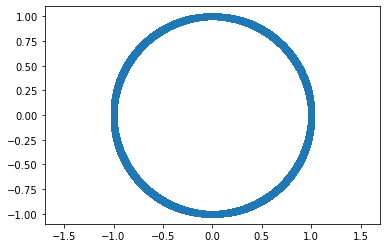

In [434]:
# evaluate validation data
visual = Visualizer(dataset)
visual.evaluate(model, x_valid_tensor_list, y_valid_tensor_list, x_valid_len_list, y_valid_len_list, x_valid_tracks, y_valid_tracks, recommender_valid)

# visualize song mat
plt.scatter(visual.song_mat[:, 0], visual.song_mat[:, 1])
plt.axis('equal')



In [529]:
from data_loader import musicdb
import json

db = musicdb.MusicDB()

def get_max_genre(stats):
    stats = json.loads(stats)
    if len(stats.keys()) == 0:
        return None
    inverse = [(value, key) for key, value in stats.items()]
    return(max(inverse)[1])

def recommend_match(visual, user_idx, K):
    user_embed = visual.get_user_embed(user_idx)[0:K]
    user_embed = user_embed.reshape((1, user_embed.shape[0], user_embed.shape[1]))
    top_10_track_ids, top_10_track_mats, recalls, others = \
        recommender_valid.recommend(user_embed, [x_valid_tracks[user_idx]], [y_valid_tracks[user_idx]], return_songs=True)
    # intersection
    inter_set = set(y_valid_tracks[user_idx]) & set(top_10_track_ids[0])
    #print(inter_set)
    indecies = [y_valid_tracks[user_idx].index(track) for track in inter_set]
    #print(user_idx, K, indecies)
    if user_idx == 56:
        if K == 1 or K == 3:
            indecies.remove(6)
            indecies.remove(10)
            indecies.remove(15)
    return indecies


def count_tag(dicts, tag):
    if tag in dicts.keys():
        dicts[tag] += 1
    else:
        dicts[tag] = 1
    return dicts

def form_a_dict(tracks):
    dicts = {}
    for track in tracks:
        song_dict = db.select_song_spotify(track)
        genre_tag = get_max_genre(song_dict['genre_top'])
        #print(genre_tag)
        dicts = count_tag(dicts, genre_tag)
    return dicts

def compare(genre_dict, genre_dict_k):
    res_dict = {}
    for genre in genre_dict.keys():
        if genre in genre_dict_k.keys():
            res_dict[genre] = "{} / {}".format(genre_dict_k[genre], genre_dict[genre])
        else:
            res_dict[genre] = "{} / {}".format(0, genre_dict[genre])
    print(res_dict)
            
    
def visualize(visual, user_id_list, K_list, preferred_embed_id_list, recommend_match=True):
    f = plt.figure(figsize=(10, 10))
    counter = 1
    for i in range(len(user_id_list)):
        liked_song, masked_song, user_embed = visual.visualize(user_id_list[i], user_embed_num=10, plot=False)
        user_id = user_id_list[i]
        all_x_tracks = x_valid_tracks[user_id]
        all_y_tracks = y_valid_tracks[user_id]
        #print(all_x_tracks)
        if recommend_match:
            x_genre_dict = form_a_dict(all_x_tracks)
            y_genre_dict = form_a_dict(all_y_tracks)
            print(x_genre_dict)
            print(y_genre_dict)
        
        # get the stat dict for genre tags
        
        for k in K_list:
            axarr = f.add_subplot(len(user_id_list), len(K_list), counter)
            if k > 0:
                plt.plot([0, user_embed[0, 0]], [0, user_embed[0, 1]], color='steelblue', label='User Embedding')
            if k > 1:
                for j in range(1, k):
                    #print(user_embed[j, 0],user_embed[j, 1])
                    plt.plot([0, user_embed[j, 0]], [0, user_embed[j, 1]], color='steelblue')
            
            # recommend match
            if recommend_match:
                indecies = recommend_match(visual, user_id_list[i], k)
                tracks = [y_valid_tracks[user_id][i] for i in indecies]
                y_genre_dict_k = form_a_dict(tracks)
                compare(y_genre_dict, y_genre_dict_k)
            
            plt.scatter(liked_song[:, 0], liked_song[:, 1], label='Given Songs', color='orange', linewidths=0.9, marker='x')
            r_x, r_y, u_x, u_y = [], [], [], []
            for n in range(masked_song.shape[0]):
                if n in indecies:
                    r_x.append(masked_song[n, 0])
                    r_y.append(masked_song[n, 1])
                    
                else:
                    u_x.append(masked_song[n, 0])
                    u_y.append(masked_song[n, 1])
            
            plt.scatter(r_x, r_y, label='Recommended Songs', color='seagreen', linewidths=0.01, marker='o')
            plt.scatter(u_x, u_y, label='Unrecommended Songs', color='red', linewidths=0.01, marker='o')
            
            plt.axis('equal')
            plt.axis([-1.1, 1.1, -1.1, 1.1])
            #print(masked_song.shape)
            tag = 'single-vector' if k == 1 else 'sequential'
            plt.title("User: {}, {}, matched: {}/{}".format(i, tag, len(indecies), len(y_valid_tracks[user_id_list[i]])))
            #plt.legend()
            counter += 1
            
            # recommend 

    lines, labels = f.axes[-1].get_legend_handles_labels()
    f.legend(lines, labels, loc='upper center')
    plt.show()
    f.savefig('visual.pdf')

Database musicdbn has already been existed.
Table echonest has already been existed.
Table echofilter has already been existed.
Table millionsonglink has already been existed.
Table spotify has already been existed.
Table songs has already been existed.


In [530]:
print(len(visual.pred_list[0]))

50


<ipython-input-433-c497580035d8>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mat = torch.matmul(torch.tensor(mat), self.V[:, :2]).numpy()
<ipython-input-433-c497580035d8>:16: RuntimeWarning: invalid value encountered in true_divide
  mat = mat / np.sqrt(mat[:, 0] * mat[:, 0] + mat[:, 1] * mat[:, 1]).reshape(mat.shape[0], 1)


user id: 46, recalls: @100: 0.6923076923076923, matched: 9 / 13
{'indie': 2, 'pop': 1, 'indie rock': 4, 'folk': 3, None: 1}
{'folk': 7, 'indie rock': 3, 'indie': 2, 'Alt-country': 1}
{'folk': '0 / 7', 'indie rock': '2 / 3', 'indie': '2 / 2', 'Alt-country': '0 / 1'}
{'folk': '5 / 7', 'indie rock': '2 / 3', 'indie': '2 / 2', 'Alt-country': '0 / 1'}
user id: 56, recalls: @100: 0.6666666666666666, matched: 16 / 24
{'blues rock': 13, 'blues': 3, 'acoustic': 2, 'rock': 1, 'indie': 2, 'singer-songwriter': 1}
{'blues rock': 15, 'singer-songwriter': 3, 'rock': 1, 'indie': 4, 'blues': 1}
{'blues rock': '12 / 15', 'singer-songwriter': '0 / 3', 'rock': '0 / 1', 'indie': '0 / 4', 'blues': '1 / 1'}
{'blues rock': '12 / 15', 'singer-songwriter': '2 / 3', 'rock': '0 / 1', 'indie': '1 / 4', 'blues': '1 / 1'}


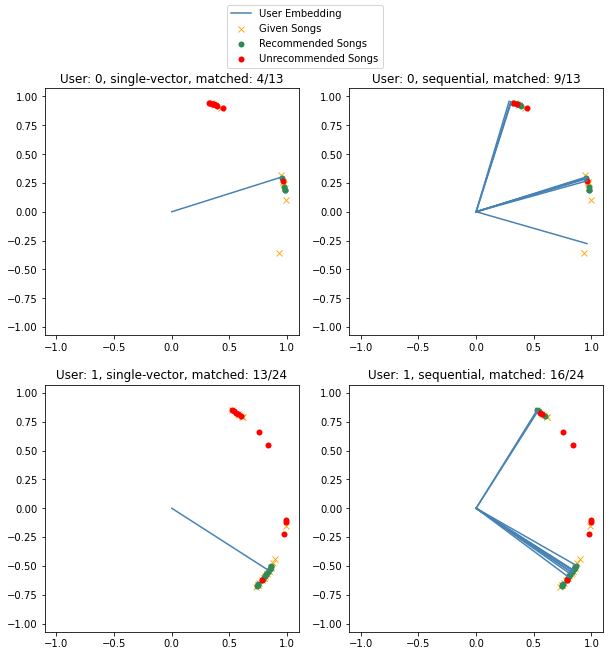

In [531]:
visualize(visual, [46, 56], [1, 10], [])

<ipython-input-433-c497580035d8>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mat = torch.matmul(torch.tensor(mat), self.V[:, :2]).numpy()
<ipython-input-433-c497580035d8>:16: RuntimeWarning: invalid value encountered in true_divide
  mat = mat / np.sqrt(mat[:, 0] * mat[:, 0] + mat[:, 1] * mat[:, 1]).reshape(mat.shape[0], 1)


user id: 66, recalls: @100: 0.5555555555555556, matched: 5 / 9
(65, 2)
(65, 2)
(65, 2)
user id: 89, recalls: @100: 0.6428571428571429, matched: 9 / 14
(65, 2)
(65, 2)
(65, 2)


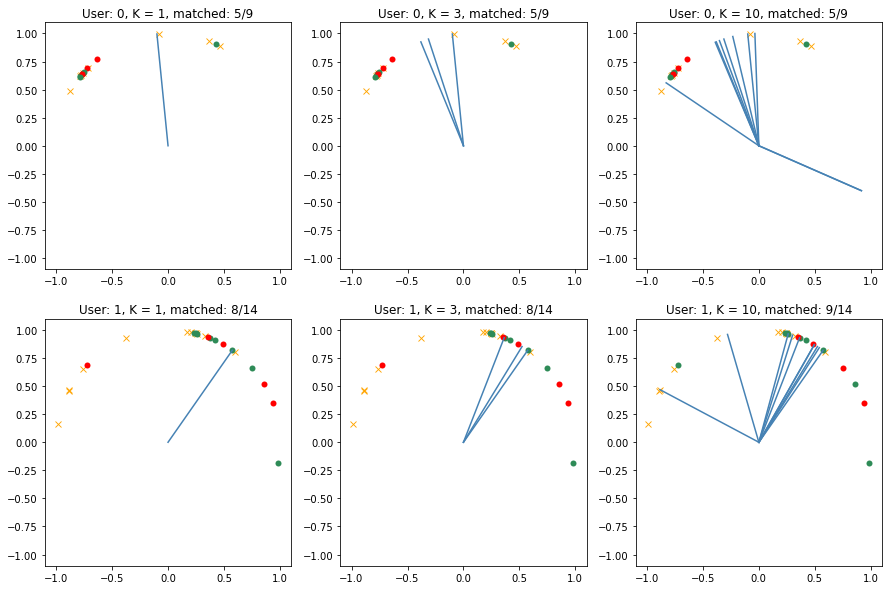

In [450]:
visualize(visual, [66, 89], [1, 3, 10], [])

<ipython-input-433-c497580035d8>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mat = torch.matmul(torch.tensor(mat), self.V[:, :2]).numpy()
<ipython-input-433-c497580035d8>:16: RuntimeWarning: invalid value encountered in true_divide
  mat = mat / np.sqrt(mat[:, 0] * mat[:, 0] + mat[:, 1] * mat[:, 1]).reshape(mat.shape[0], 1)


user id: 75, recalls: @100: 0.5, matched: 6 / 12
(65, 2)
(65, 2)
(65, 2)
user id: 38, recalls: @100: 0.46875, matched: 15 / 32
(65, 2)
(65, 2)
(65, 2)


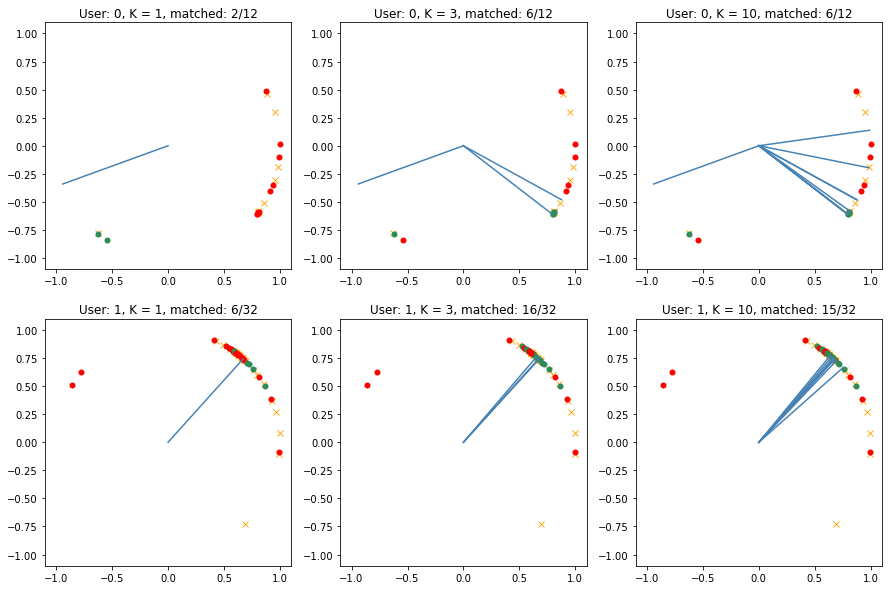

In [451]:
visualize(visual, [75, 38], [1, 3, 10], [])

<ipython-input-433-c497580035d8>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mat = torch.matmul(torch.tensor(mat), self.V[:, :2]).numpy()
<ipython-input-433-c497580035d8>:16: RuntimeWarning: invalid value encountered in true_divide
  mat = mat / np.sqrt(mat[:, 0] * mat[:, 0] + mat[:, 1] * mat[:, 1]).reshape(mat.shape[0], 1)


user id: 20, recalls: @100: 0.2857142857142857, matched: 4 / 14
(65, 2)
(65, 2)
(65, 2)
user id: 4, recalls: @100: 0.2857142857142857, matched: 2 / 8
(65, 2)
(65, 2)
(65, 2)


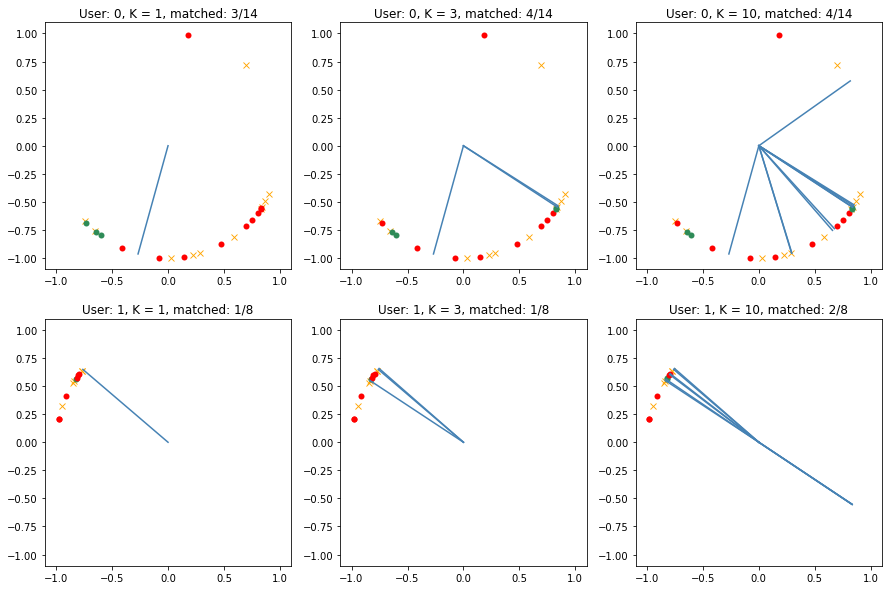

In [452]:
visualize(visual, [20, 4], [1, 3, 10], [])

[ 0 61 21 60 59 54 25 64 50 29 44 31 32 43 34 28 17 18 76  1  2 93 85 84
 83 77 16 42 74 73 11 12 70 69 68 35 51 49 23 52 98 71 96 39 36 41 47  6
 53 45 48  9 79 40 15 10 14 26 33 58 62 57 65 67 95 97 99 91 72  7 24 30
 27 86 19 13  5 81 22 90  4 20 37 55 80 63 88 87 92  8  3 78 94 82 38 75
 66 89 56 46]
48
top_k: [46 56 89 66 75 38 82 94 78  3  8 92 87 88 63 80 55 37 20  4]
bottom_k: [ 0 61 21 60 59 54 25 64 50 29 44 31 32 43 34 28 17 18 76  1]
Recall = 0:  35.0 35.0%
Recall > 0:  65.0 65.0%
0.13814926525098667


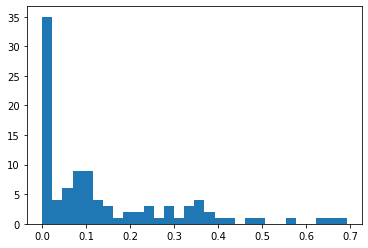

In [432]:
k = 20

args = np.argsort(np.array(visual.recall_list))

print(args)
print(args[int(len(args) / 2)])

top_k_arg = args[-k:]
bottom_k_arg = args[:k]
print('top_k:', np.flip(top_k_arg))
print('bottom_k:', bottom_k_arg)

num = plt.hist(visual.recall_list, bins=30)
print('Recall = 0: ', num[0][0], "{}%".format(num[0][0] * 100 / (num[0][0] + num[0][1:].sum())))
print('Recall > 0: ',num[0][1:].sum(), "{}%".format(num[0][1:].sum() * 100 / (num[0][0] + num[0][1:].sum())))
print(sum(visual.recall_list)/len(visual.recall_list))

In [538]:
# evaluate validation data without normalization ----------------------------------------------------------------------------
visual = Visualizer(dataset, normalize=False)
visual.evaluate(model, x_valid_tensor_list, y_valid_tensor_list, x_valid_len_list, y_valid_len_list, x_valid_tracks, y_valid_tracks, recommender_valid)

  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

Visualizer init


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.03s/it]


<ipython-input-537-2b91b83be857>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mat = torch.matmul(torch.tensor(mat), self.V[:, :2]).numpy()


user id: 46, recalls: @100: 0.6923076923076923, matched: 9 / 13


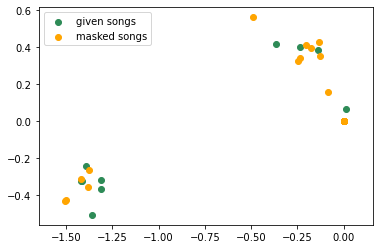

<ipython-input-537-2b91b83be857>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mat = torch.matmul(torch.tensor(mat), self.V[:, :2]).numpy()


user id: 56, recalls: @100: 0.6666666666666666, matched: 16 / 24


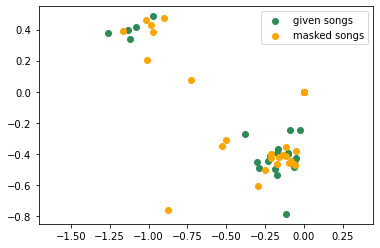

<ipython-input-537-2b91b83be857>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mat = torch.matmul(torch.tensor(mat), self.V[:, :2]).numpy()


user id: 89, recalls: @100: 0.6428571428571429, matched: 9 / 14


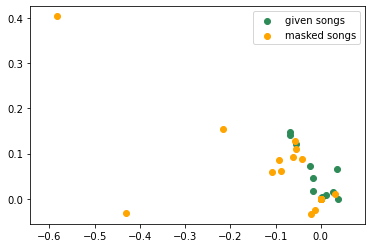

'\nvisual.visualize(89, user_embed_num=embed_num)\nvisual.visualize(5, user_embed_num=embed_num)\n\nvisual.visualize(95, user_embed_num=embed_num)\nvisual.visualize(94, user_embed_num=embed_num)\n\nvisual.visualize(0, user_embed_num=embed_num)\nvisual.visualize(64, user_embed_num=embed_num)\n'

In [539]:
embed_num = 5

# genre + audio
'''
visual.visualize(46, user_embed_num=embed_num)
visual.visualize(56, user_embed_num=embed_num)

visual.visualize(99, user_embed_num=embed_num)
visual.visualize(91, user_embed_num=embed_num)

visual.visualize(0, user_embed_num=embed_num)
visual.visualize(61, user_embed_num=embed_num)
'''
# lyric
'''
visual.visualize(91, user_embed_num=embed_num)
visual.visualize(67, user_embed_num=embed_num)

visual.visualize(31, user_embed_num=embed_num)
visual.visualize(30, user_embed_num=embed_num)

visual.visualize(0, user_embed_num=embed_num)
visual.visualize(71, user_embed_num=embed_num)
'''

# genre

visual.visualize(46, user_embed_num=embed_num)
visual.visualize(56, user_embed_num=embed_num)
visual.visualize(89, user_embed_num=embed_num)

#.visualize(99, user_embed_num=embed_num)
#visual.visualize(91, user_embed_num=embed_num)

#visual.visualize(0, user_embed_num=embed_num)
#visual.visualize(61, user_embed_num=embed_num)

# audio
'''
visual.visualize(89, user_embed_num=embed_num)
visual.visualize(5, user_embed_num=embed_num)

visual.visualize(95, user_embed_num=embed_num)
visual.visualize(94, user_embed_num=embed_num)

visual.visualize(0, user_embed_num=embed_num)
visual.visualize(64, user_embed_num=embed_num)
'''

Database musicdbn has already been existed.
Table echonest has already been existed.
Table echofilter has already been existed.
Table millionsonglink has already been existed.
Table spotify has already been existed.
Table songs has already been existed.
user id: 46, recalls: @100: 0.6923076923076923, matched: 9 / 13
(64, 2)
(65, 2)
user id: 56, recalls: @100: 0.6666666666666666, matched: 16 / 24
(63, 2)
(65, 2)
user id: 99, recalls: @100: 0.125, matched: 3 / 24
(63, 2)
(65, 2)
user id: 91, recalls: @100: 0.14285714285714285, matched: 4 / 28
(63, 2)
(65, 2)
user id: 0, recalls: @100: 0.0, matched: 0 / 11
(64, 2)
(65, 2)
user id: 61, recalls: @100: 0.0, matched: 0 / 9
(63, 2)
(65, 2)


<ipython-input-537-2b91b83be857>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mat = torch.matmul(torch.tensor(mat), self.V[:, :2]).numpy()


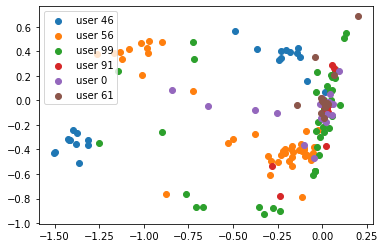

In [541]:
from data_loader import musicdb
import json

db = musicdb.MusicDB()

def get_max_genre(stats):
    stats = json.loads(stats)
    if len(stats.keys()) == 0:
        return []
    inverse = [(value, key) for key, value in stats.items()]
    return(max(inverse)[1])

user_id_list = [46, 56, 99, 91, 0, 61]
plt.figure()
for user_id in user_id_list:
    liked_song, masked_song, _ = visual.visualize(user_id, user_embed_num=5, plot=False, normalize=False)
    print(liked_song.shape)
    print(masked_song.shape)
    all_song = np.concatenate([liked_song, masked_song], axis=0)
    #plt.scatter(liked_song[:, 0], liked_song[:, 1], label='user {} liked songs'.format(user_id))
    #plt.scatter(masked_song[:, 0], masked_song[:, 1], label='user {} masked songs'.format(user_id))
    plt.scatter(all_song[:, 0], all_song[:, 1], label='user {}'.format(user_id))
    
#     for track in x_valid_tracks[user_id]:
#         song_dict = db.select_song_spotify(track)
#         print("title: {}, \t\tgenre: {}".format(song_dict['track_name'], get_max_genre(song_dict['genre_top'])))
#     print("-----------------------------------------------------------------")
#     for track in y_valid_tracks[user_id]:
#         song_dict = db.select_song_spotify(track)
#         print("title: {}, \t\tgenre: {}".format(song_dict['track_name'], get_max_genre(song_dict['genre_top'])))
    
plt.legend()
plt.show()


    

In [551]:
def get_rank(track_id, user_idx):
    return visual.recom_id_list[int(user_idx / batch_size)][2*(user_idx - batch_size * int(user_idx / batch_size))].index(track_id)

for user_id in user_id_list:
    print(user_id)
    for track in visual.matched_list[user_id]:
        song_dict = db.select_song_spotify(track)
        print("title: {}, \t\tgenre: {}, rank: {}".format(song_dict['track_name'], get_max_genre(song_dict['genre_top']), get_rank(track, user_id)))
    print("------------------------------------")

46
title: The Pirate's Gospel, 		genre: folk, rank: 27
title: Pieces Of String, 		genre: folk, rank: 17
title: Neighborhood #4 (Kettles), 		genre: indie rock, rank: 7
title: (Antichrist Television Blues), 		genre: indie rock, rank: 14
title: Pigeon Song, 		genre: folk, rank: 25
title: Ocean Of Noise, 		genre: indie, rank: 1
title: Foreign Tongue, 		genre: folk, rank: 20
title: Something's Gone Awry, 		genre: folk, rank: 21
title: My Body Is A Cage, 		genre: indie, rank: 8
------------------------------------
56
title: Till I Get My Way, 		genre: blues rock, rank: 6
title: Brooklyn Bound, 		genre: blues rock, rank: 0
title: Keep Me, 		genre: blues rock, rank: 99
title: All Hands Against His Own, 		genre: blues rock, rank: 2
title: Modern Times, 		genre: blues, rank: 36
title: 240 Years Before Your Time, 		genre: blues rock, rank: 34
title: Countdown, 		genre: blues rock, rank: 69
title: Black Door, 		genre: blues rock, rank: 9
title: Goodbye Babylon, 		genre: blues rock, rank: 3
title: 

In [550]:
set(visual.recom_id_list[0][46]) & set(visual.matched_list[46])

set()

In [ ]:
# evaluate validation data
visual = Visualizer(dataset)
visual.evaluate(model, x_valid_tensor_list, y_valid_tensor_list, x_valid_len_list, y_valid_len_list, x_valid_tracks, y_valid_tracks, recommender_valid)

In [124]:
len(visual.y_track)

973

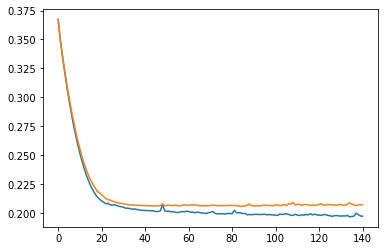

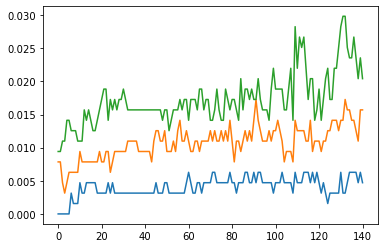

In [9]:
# visualize training process
pkl_path = 'E:\dataset\echo_nest\sub_data\genre_meta_musicnn_none\\b_50_lr_0.001_head_1.pkl'
with open(pkl_path, 'rb') as f:
    recorders = pickle.load(f)
    train_loss_batch = recorders['train_loss_batch']
    train_loss_epoch = recorders['train_loss_epoch']
    valid_loss_epoch = recorders['valid_loss_epoch']
    recall_epoch = recorders['recall_epoch']

plt.figure(1)
plt.plot(train_loss_epoch)
plt.plot(valid_loss_epoch)

recalls = np.array(recall_epoch)
plt.figure(2)
plt.plot(recalls[:, 0])
plt.plot(recalls[:, 1])
plt.plot(recalls[:, 2])